In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
def load_data(filename):
    """function to load data"""
    x = scipy.io.loadmat(filename)['PDmean'][20:100,:]*100
    return x

In [3]:
global T4_Arclight, T4_Gcamp #global varaiables to hold Arclight and Gcamp data

filename = 'data/T4c_ArcLight/ARCOri_Velocity_Mean.mat' 
T4_Arclight = load_data(filename)  #load Arclight data

filename = 'data/T4c_GCaMP/Ori_Mean_Velocity.mat'
T4_Gcamp = load_data(filename)  #load Gcamp data

In [26]:
def plot_data(data_list, dt=0.0769, fig_size=(12,12), speed=[15,30,60,120], title='', savefig=False, c=['k','r']):
    """Plots data for multiple datsets"""
    n_col = len(speed) #number of columns i.e. number of speed stimuli
    n_sti = data_list[0].shape[1] #number of orientations
    #x_values = np.arange(data_list[0].shape[0]) * dt #changing x-axis to time. multiply with time step dt = 1/frequency
    f, ax = plt.subplots(int(n_sti/n_col), int(n_col), sharex=True, sharey= True, figsize=fig_size)
    c_count = 0 #color count for different dataset
    for data in data_list:
        count = 0 #count for stimuli
        for i in range(int(n_sti/n_col)):
            for j in range(n_col):
                #ax[i, j].plot(x_values, data[:, count], color=c[c_count])
                ax[i, j].plot(data[:, count], color=c[c_count])
                count = count + 1
        c_count += 1
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        
def plot_data_twinaxis(data_list, dt=0.0769, ylim=(-20,250),fig_size=(12,12), speed=[15,30,60,120], title='', savefig=False, c=['k','r']):
    """Plots data for multiple datsets"""
    n_col = len(speed) #number of columns i.e. number of speed stimuli
    n_sti = data_list[0].shape[1] #number of orientations
    x_values = np.arange(data_list[0].shape[0]) * dt #changing x-axis to time. multiply with time step dt = 1/frequency
    f, ax = plt.subplots(int(n_sti/n_col), int(n_col), sharex=True, sharey= True, figsize=fig_size)
    c_count = 0 #color count for different dataset
    for data in data_list:
        count = 0 #count for stimuli
        for i in range(int(n_sti/n_col)):
            for j in range(n_col):
                if c_count == 0:
                    ax[i, j].plot(x_values, data[:, count], color=c[c_count])
                else :
                    ax1 = ax[i,j].twinx()
                    ax1.plot(x_values, data[:, count], color=c[c_count])
                    ax1.set_ylim(ylim)
                #ax[i, j].plot(data[:, count], color=c[c_count])
                count = count + 1
        c_count += 1
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);

In [7]:
def lowpass(x, tau, dt):
    y = np.zeros_like(x)
    n = x.shape[0]   #length of time dimension
    alpha = dt / (tau+dt)
    y[0] = x[0]
    for i in np.arange(1,n):
        y[i] = alpha*x[i] + (1-alpha)*y[i-1]
    return y

def highpass(x, tau, dt):
    y = x - lowpass(x, tau, dt)
    return y

def bandpass(x, tauhp, taulp, dt):
    y = highpass(x, tauhp, dt)
    y = lowpass(y, taulp, dt)
    return y

def threshold_cut(x, thres):
    x_copy = x.copy()
    x_copy[x_copy<thres] = 0
    return x_copy 

def Ca_model(x, thres, tauhp, taulp1, gain1, taulp2, gain2, dt=0.0769):
    x_thres = threshold_cut(x,thres)
    x_thres_bp1 = bandpass(x_thres, tauhp, taulp1, dt)
    x_1 = x_thres_bp1 * gain1
    x_thres_bp2 = bandpass(x_thres, tauhp, taulp2, dt)
    x_2 = x_thres_bp2 * gain2
    y = x_1 + x_2
    #y = np.roll(y, int(tshift), axis=0)
    return y

def Ca_model_1(x, thres, tauhp, taulp1, gain1, dt=0.0769):
    x_thres = threshold_cut(x,thres)
    x_thres_hp = highpass(x_thres, tauhp, dt)
    x_thres_hp_lp = lowpass(x_thres_hp, taulp1, dt)
    y = x_thres_hp_lp * gain1
    return y

def Ca_model_2(x, thres, tauhp, taulp1, taulp2, gain, dt=0.0769):
    x_thres = threshold_cut(x, thres)
    x_thres_hp = highpass(x_thres, tauhp, dt)
    x_thres_hp_lp1 = lowpass(x_thres_hp, taulp1, dt)
    #x_thres_hp_lp1 = shift_signal(x_thres_hp_lp1, T4Ca_model, vel=15.0)
    x_thres_hp_lp2 = lowpass(x_thres_hp, taulp2, dt) 
    #x_thres_hp_lp2 = shift_signal(x_thres_hp_lp2, T4Ca_model, vel=15.0)
    y = (x_thres_hp_lp1 + x_thres_hp_lp2)*gain
    #plot_data([x, x_thres, x_thres_hp, x_thres_hp_lp1, x_thres_hp_lp2, y], c=['k','r','g','blue','brown','grey']);
    return y

def Ca_model_3(x, thres, tauhp, taulp1, taulp2, gain1, gain2, dt=0.0769):
    x_thres = threshold_cut(x, thres)
    x_thres_hp = highpass(x_thres, tauhp, dt)
    x_thres_hp_lp1 = lowpass(x_thres_hp, taulp1, dt)
    x_thres_hp_lp1 = x_thres_hp_lp1 * gain1
    #x_thres_hp_lp1 = shift_signal(x_thres_hp_lp1, T4Ca_model, vel=15.0)
    x_thres_hp_lp2 = lowpass(x_thres_hp, taulp2, dt)
    x_thres_hp_lp2 = x_thres_hp_lp2 * gain2
    #x_thres_hp_lp2 = shift_signal(x_thres_hp_lp2, T4Ca_model, vel=15.0)
    y = x_thres_hp_lp1 + x_thres_hp_lp2
    #plot_data([x, x_thres, x_thres_hp, x_thres_hp_lp1, x_thres_hp_lp2, y], c=['k','r','g','blue','brown','grey']);
    return y

def shift_signal(gcamp_data, model_data, vel):
    if vel == 15.0:
        shift_columns = np.argmax(gcamp_data[45:70,:],axis=0)-np.argmax(model_data[45:70,:],axis=0)
    elif vel == 30.0:
        shift_columns = np.argmax(gcamp_data[15:25,:],axis=0)-np.argmax(model_data[15:25,:],axis=0)
    A = model_data
    r = shift_columns
    rows, columns = np.ogrid[:A.shape[0], :A.shape[1]]
    r[r < 0] += A.shape[0]
    rows = rows - r[np.newaxis,:]
    model_shift = A[rows, columns]
    return model_shift

In [12]:
def calc_peaktuning(data_list, speed):
    peak_tuning = np.empty((len(data_list),len(speed),12)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
                                #second dimension is for 4 speeds, 3rd dimension is for 12 directions
    for j in range(len(data_list)):
        for i in range(4):
            peak_tuning[j,i,:] = data_list[j][:,i:48+i:4].max(axis=0)
    return peak_tuning

def plot_oripeaktuning(data_list, speed, color, ylim=(0,200), fig_size=(15,8), title='',savefig=False):
    peak_tuning = calc_peaktuning(data_list, speed)
            
    def polar_plot(data, rotations_rad, ax, ylim,marker='o', color='r'):
        data = np.append(data, data[0])
        ax.plot(rotations_rad, data, marker=marker, color=color)
        ax.set_ylim(ylim)
        
    rotations = np.arange(0.0,390.0,30.0)
    rotations_rad = (rotations * np.pi) / 180
    fig, ax = plt.subplots(2,4,subplot_kw={'projection': 'polar'}, figsize=(15,8))
    for j in range(2):
        for i in range(4):
            if j == 1:
                polar_plot(peak_tuning[1,i,:], rotations_rad, ax[1][i], ylim=(0,225),color='b' );
                polar_plot(peak_tuning[2,i,:], rotations_rad, ax[1][i], ylim=(0,225),color='r' );
            if j == 0:
                polar_plot(peak_tuning[0,i,:], rotations_rad, ax[0][i], ylim=(0,7.0),color='k' );
    plt.subplots_adjust()
    plt.tight_layout();
    #ax[1][0].arrow(0,0,angle_rad, mag*200)
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);
        
def plot_Ldir(peak_tuning,fig_size=(15,4), title='',savefig=False):
    Ldir_array = np.empty((peak_tuning.shape[0],peak_tuning.shape[1],2)) #first dimesnion is for Arclight, Gcamp, Model respectively. 
                                #second dimension is for 4 speeds, 3rd dimension is for angle and magnitude
    def Ldir(data):
        rot = np.arange(0.0,360.0,30.0)
        rot_rad = (rot*np.pi)/180
        data_x = np.sum(data*np.cos(rot_rad))
        data_y = np.sum(data*np.sin(rot_rad))
        angle_rad = np.arctan(data_y/data_x)
        if angle_rad <0.0:
            angle_rad = angle_rad+np.pi
        mag = np.sqrt(data_y**2 + data_x**2) / np.sum(data)
        return (angle_rad, mag)
    
    for j in range(peak_tuning.shape[0]):
        for i in range(peak_tuning.shape[1]):
            Ldir_array[j,i,:] = Ldir(peak_tuning[j,i,:])
    Ldir_array = np.nan_to_num(Ldir_array)
    
    fig, ax = plt.subplots(1,4,subplot_kw={'projection': 'polar'}, figsize=fig_size)
    for i in range(4):
        ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[0,i,0],Ldir_array[0,i,1]),arrowprops=dict(facecolor='black'))
        ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[1,i,0],Ldir_array[1,i,1]),
                       arrowprops=dict(facecolor='blue'))
        ax[i].annotate("", xytext=(0.0,0.0), xy=(Ldir_array[2,i,0],Ldir_array[2,i,1]),arrowprops=dict(facecolor='red'))
    plt.tight_layout();    
    if savefig:
        plt.savefig('figures/'+title+'.pdf',dpi=1000);

In [6]:
dt=0.0769
thres_val = np.linspace(-5,4,10)
tauhp_val = np.linspace(0,2,10)
taulp1_val = np.linspace(0,6,10)
gain1_val = np.linspace(0,500,10)
taulp2_val = np.linspace(0,6,10)
gain2_val = np.linspace(0,500,10)
gain_val = np.linspace(0,500,10)
#tshift_val = np.linspace(-50, 50, 5)

In [40]:
#CalciumModel 1
error_list = []
para_dict = {}
counter = 0
for thres in thres_val:
    for tauhp in tauhp_val:
        for taulp1 in taulp1_val:
            for gain1 in gain1_val:
                T4Ca_model = Ca_model_1(T4_Arclight, thres, tauhp, taulp1, gain1)
                T4Ca_model[:,0:48:4] = shift_signal(T4_Gcamp[:,0:48:4], T4Ca_model[:,0:48:4], vel=15.0) #shift 15degpersec speed signals
                T4Ca_model[:,1:49:4] = shift_signal(T4_Gcamp[:,1:49:4], T4Ca_model[:,1:49:4], vel=30.0) #shift 30degpersec speed signals
                error1 = np.mean(np.sqrt(np.mean((T4_Gcamp[10:70,:]-T4Ca_model[10:70,:])**2,axis=0)))
                error2 = np.sqrt(np.mean((T4_Gcamp[45:70,:].max(axis=0)-T4Ca_model[45:70,:].max(axis=0))**2)) #lastpeakerror
                timeerror = 0.7 #weight for time error
                error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
                error_list.append(error)
                para_dict[counter] = (thres, tauhp, taulp1, gain1)
                counter +=1

In [41]:
model_p = para_dict[np.argmin(error_list)]
(thres_model, tauhp_model, taulp1_model, gain1_model) = model_p
#(thres_model, tauhp_model, taulp1_model, gain1_model) = (3.5, 2.0, 5.333333333333333, 222.22222222222223)
(np.min(error_list),thres_model, tauhp_model, taulp1_model, gain1_model)

(19.103479859386795, 3.0, 2.0, 5.333333333333333, 222.22222222222223)

In [42]:
T4_model = Ca_model_1(T4_Arclight, thres_model, tauhp_model, taulp1_model, gain1_model)
T4_model[:,0:48:4] = shift_signal(T4_Gcamp[:,0:48:4], T4_model[:,0:48:4], vel=15.0) #shift 15degpersec speed signals
T4_model[:,1:49:4] = shift_signal(T4_Gcamp[:,1:49:4], T4_model[:,1:49:4], vel=30.0) #shift 30degpersec speed signals
                

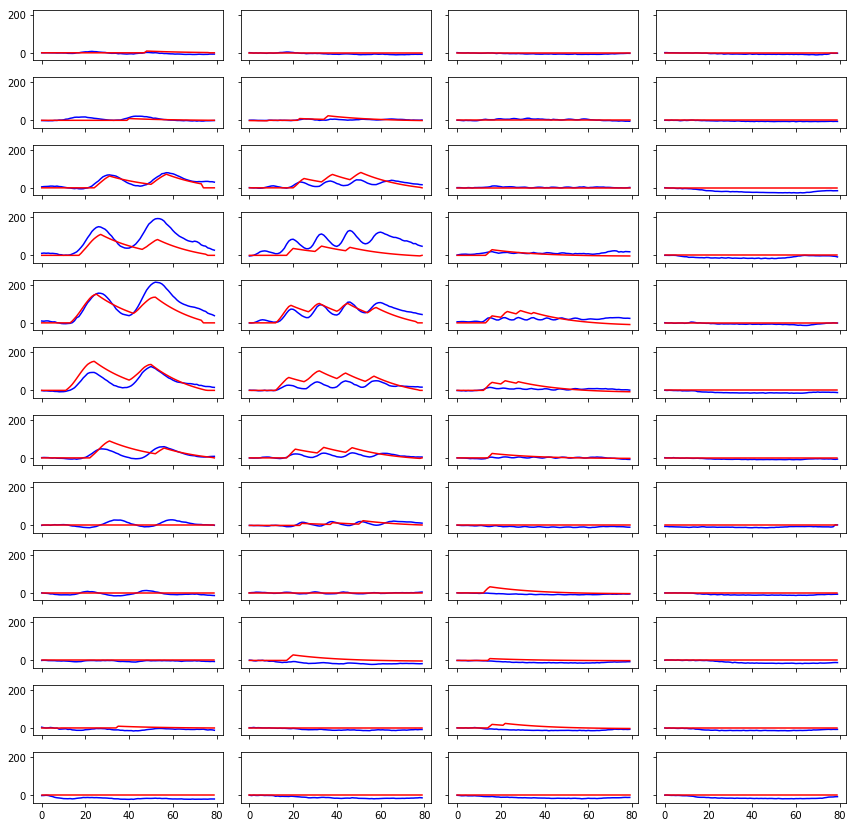

In [43]:
plot_data([T4_Gcamp, T4_model],c=['b','r'])

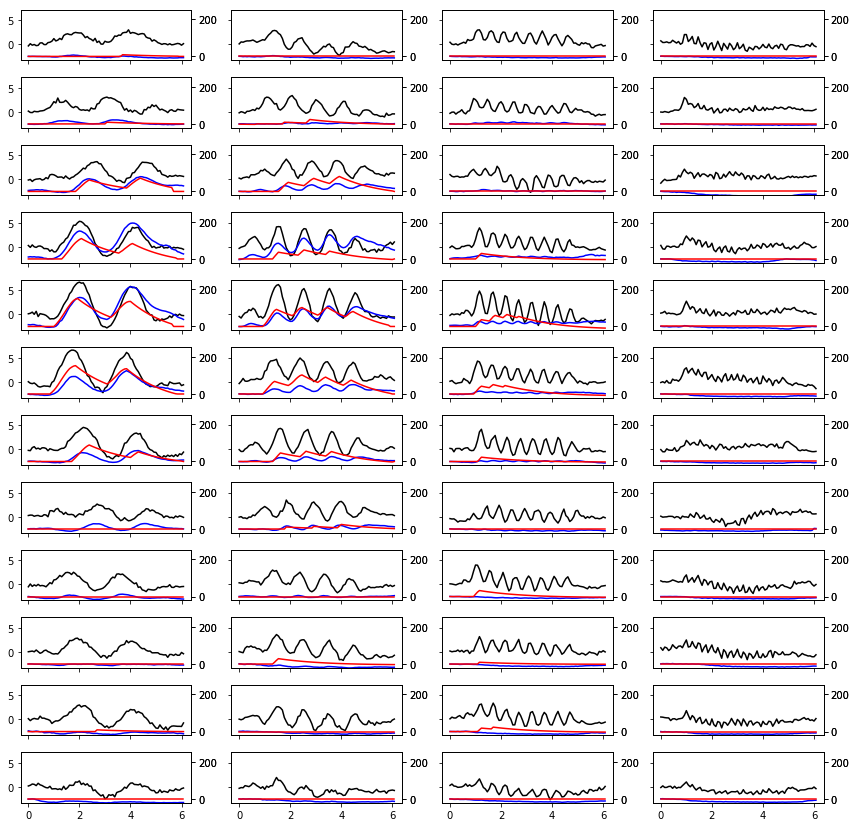

In [44]:
plot_data_twinaxis([T4_Arclight, T4_Gcamp, T4_model], c=['k','b','r'])

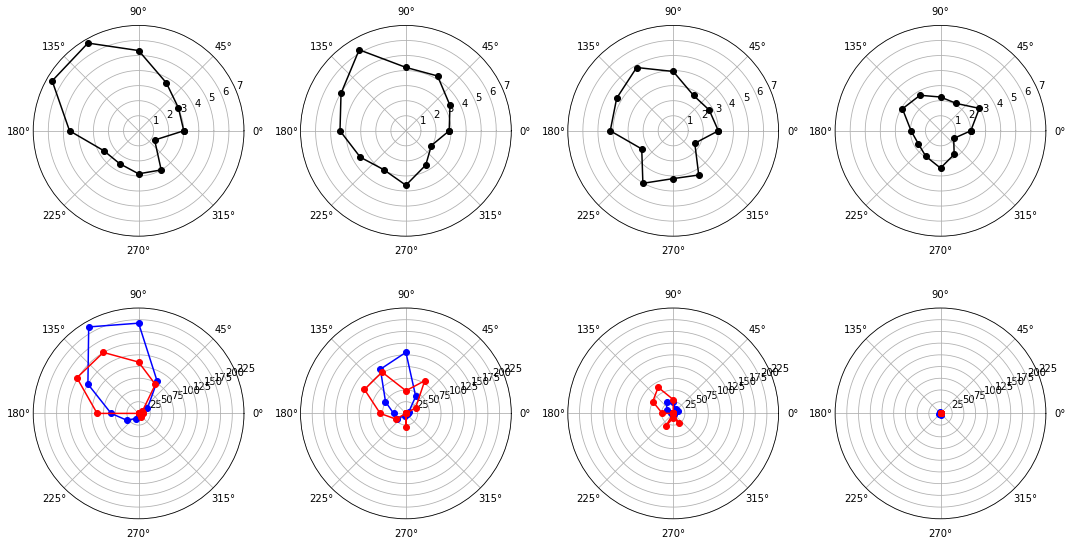

In [48]:
data_list = [T4_Arclight, T4_Gcamp, T4_model]
velocity = [15, 30, 60, 120]
peak_tuning = calc_peaktuning(data_list, speed=velocity)
plot_oripeaktuning(data_list,speed=velocity, color=['k','b','r'],title='PeakResponse_OrientationTuning_Model1',savefig=True);

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


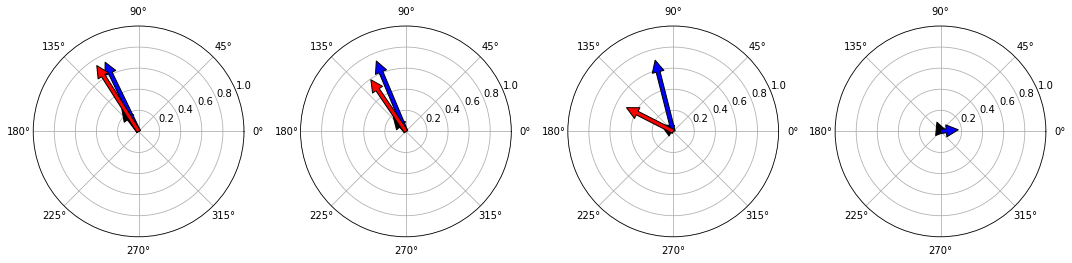

In [47]:
plot_Ldir(peak_tuning,title='Ldir_Model1',savefig=True);

In [ ]:
#CalciumModel 2

In [49]:
#CalciumModel 2
error_list = []
para_dict = {}
counter = 0
for thres in thres_val:
    for tauhp in tauhp_val:
        for taulp1 in taulp1_val:
            for taulp2 in taulp2_val:
                for gain in gain_val:
                    T4Ca_model = Ca_model_2(T4_Arclight, thres, tauhp, taulp1, taulp2, gain)
                    T4Ca_model[:,0:48:4] = shift_signal(T4_Gcamp[:,0:48:4], T4Ca_model[:,0:48:4], vel=15.0) #shift 15degpersec speed signals
                    T4Ca_model[:,1:49:4] = shift_signal(T4_Gcamp[:,1:49:4], T4Ca_model[:,1:49:4], vel=30.0) #shift 30degpersec speed signals
                    error1 = np.mean(np.sqrt(np.mean((T4_Gcamp[10:70,:]-T4Ca_model[10:70,:])**2,axis=0)))
                    error2 = np.sqrt(np.mean((T4_Gcamp[45:70,:].max(axis=0)-T4Ca_model[45:70,:].max(axis=0))**2)) #peakerror
                    timeerror = 0.7 #weight for time error
                    error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
                    error_list.append(error)
                    para_dict[counter] = (thres, tauhp, taulp1, taulp2, gain)
                    counter +=1

In [50]:
model_p = para_dict[np.argmin(error_list)]
(thres_model, tauhp_model, taulp1_model, taulp2_model, gain_model) = model_p
(np.min(error_list),thres_model, tauhp_model, taulp1_model, taulp2_model, gain_model)

(19.09469247103405, 3.0, 2.0, 5.333333333333333, 6.0, 111.11111111111111)

In [51]:
T4_model = Ca_model_2(T4_Arclight, thres_model, tauhp_model, taulp1_model, taulp2_model, gain_model)
T4_model[:,0:48:4] = shift_signal(T4_Gcamp[:,0:48:4], T4_model[:,0:48:4], vel=15.0) #shift 15degpersec speed signals
T4_model[:,1:49:4] = shift_signal(T4_Gcamp[:,1:49:4], T4_model[:,1:49:4], vel=30.0) #shift 30degpersec speed signals
 

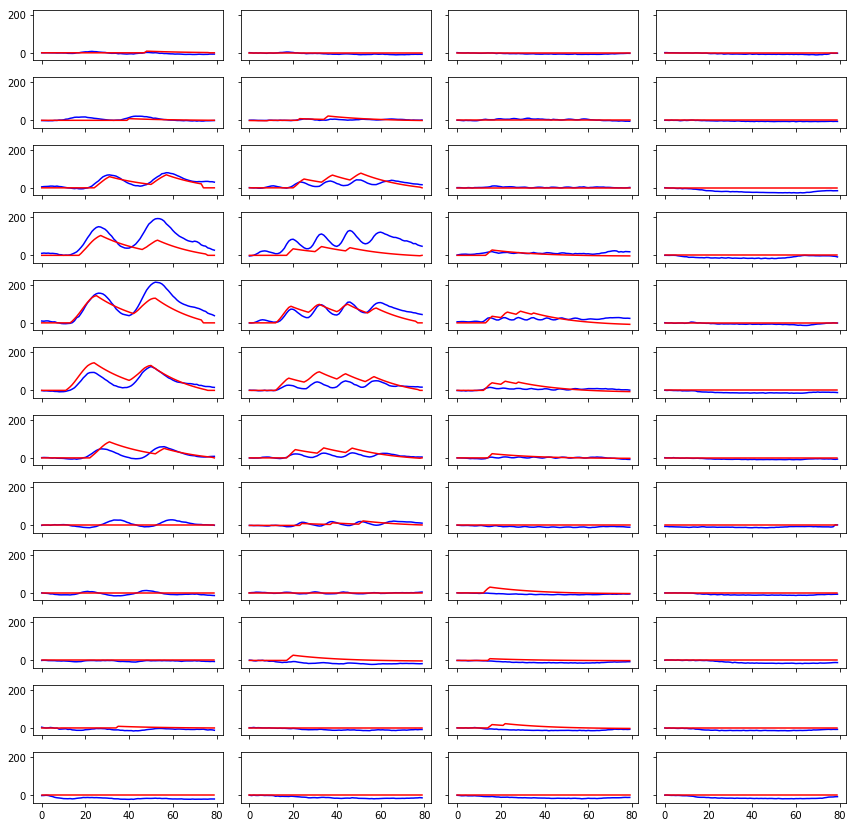

In [52]:
plot_data([T4_Gcamp, T4_model],c=['b','r'])

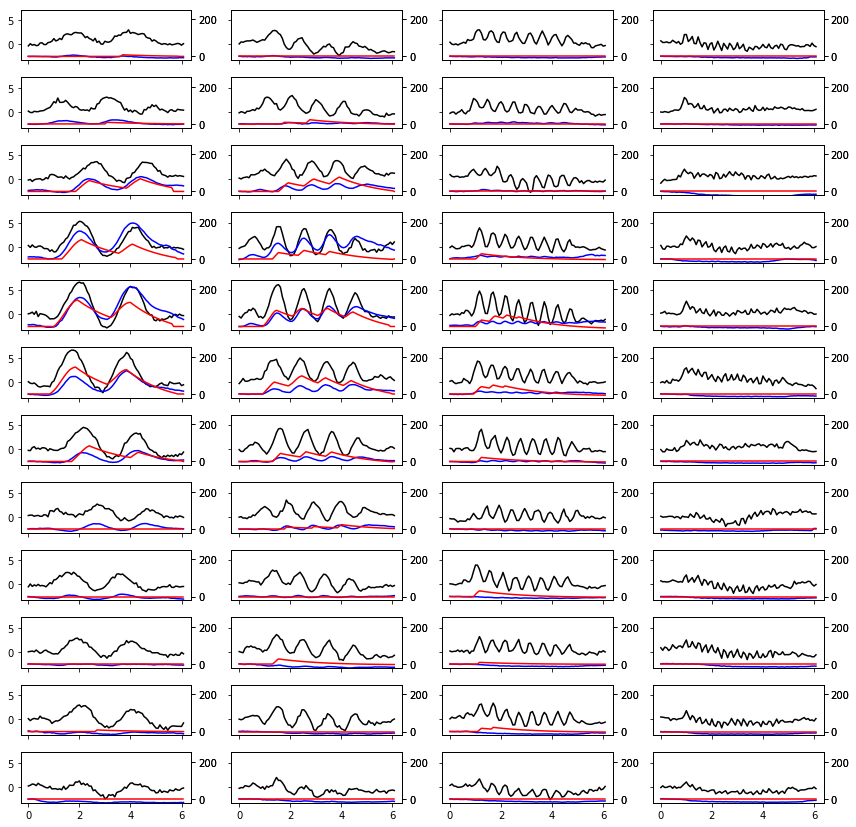

In [53]:
plot_data_twinaxis([T4_Arclight, T4_Gcamp, T4_model], c=['k','b','r'])

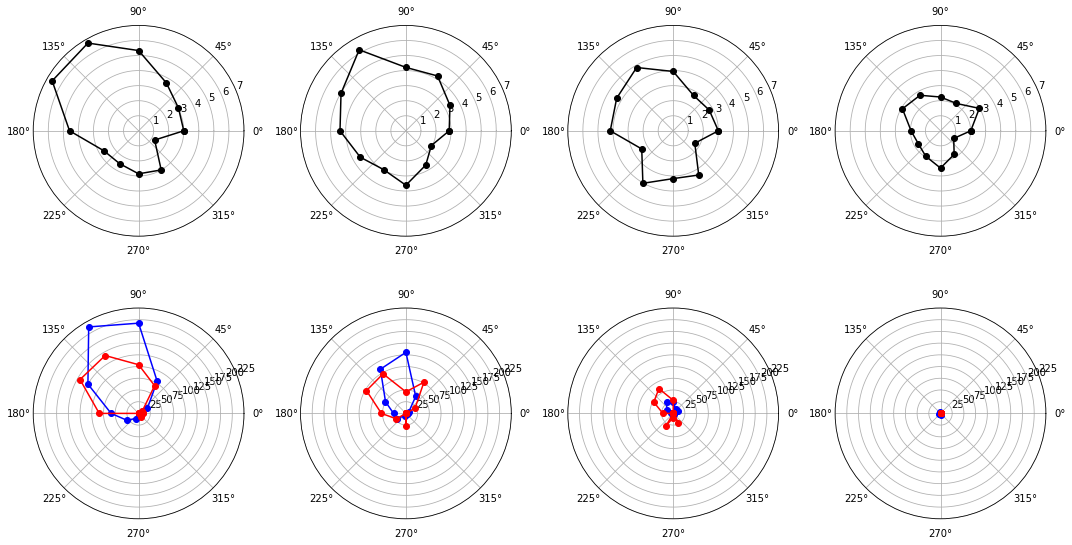

In [56]:
data_list = [T4_Arclight, T4_Gcamp, T4_model]
velocity = [15, 30, 60, 120]
peak_tuning = calc_peaktuning(data_list, speed=velocity)
plot_oripeaktuning(data_list,speed=velocity, color=['k','b','r'],title='Model2/PeakResponse_OrientationTuning_Model2',savefig=True);

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


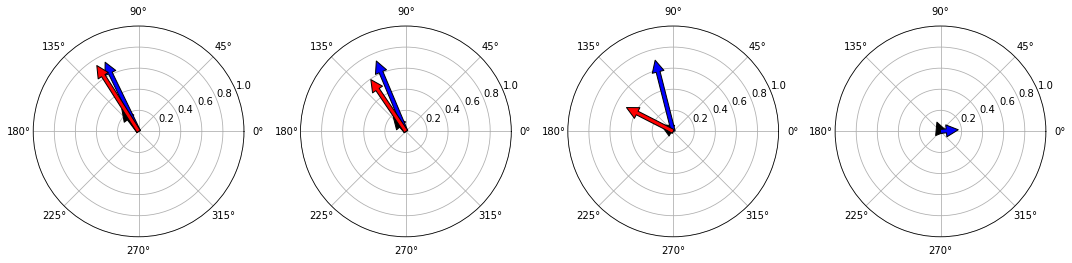

In [55]:
plot_Ldir(peak_tuning,title='Model2/Ldir',savefig=True);

In [8]:
#CalciumModel 3
error_list = []
para_dict = {}
counter = 0
for thres in thres_val:
    for tauhp in tauhp_val:
        for taulp1 in taulp1_val:
            for taulp2 in taulp2_val:
                for gain1 in gain1_val:
                    for gain2 in gain2_val:
                        T4Ca_model = Ca_model_3(T4_Arclight, thres, tauhp, taulp1, taulp2, gain1, gain2)
                        T4Ca_model[:,0:48:4] = shift_signal(T4_Gcamp[:,0:48:4], T4Ca_model[:,0:48:4], vel=15.0) #shift 15degpersec speed signals
                        T4Ca_model[:,1:49:4] = shift_signal(T4_Gcamp[:,1:49:4], T4Ca_model[:,1:49:4], vel=30.0) #shift 30degpersec speed signals
                        error1 = np.mean(np.sqrt(np.mean((T4_Gcamp[10:70,:]-T4Ca_model[10:70,:])**2,axis=0)))
                        error2 = np.sqrt(np.mean((T4_Gcamp[45:70,:].max(axis=0)-T4Ca_model[45:70,:].max(axis=0))**2)) #peakerror
                        #error2 = np.sqrt(np.mean((T4_Gcamp.max(axis=0)-T4Ca_model.max(axis=0))**2)) #peakerror
                        
                        timeerror = 0.7 #weight for time error
                        error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
                        error_list.append(error)
                        para_dict[counter] = (thres, tauhp, taulp1, taulp2, gain1, gain2)
                        counter +=1

In [9]:
model_p = para_dict[np.argmin(error_list)]
(thres_model, tauhp_model, taulp1_model, taulp2_model, gain1_model, gain2_model) = model_p
(np.min(error_list),thres_model, tauhp_model, taulp1_model, taulp2_model, gain1_model, gain2_model)

(19.093274583916468,
 3.0,
 2.0,
 5.333333333333333,
 6.0,
 166.66666666666669,
 55.55555555555556)

In [20]:
T4_model = Ca_model_3(T4_Arclight, thres_model, tauhp_model, taulp1_model, taulp2_model, gain1_model,gain2_model)
T4_model[:,0:48:4] = shift_signal(T4_Gcamp[:,0:48:4], T4_model[:,0:48:4], vel=15.0) #shift 15degpersec speed signals
T4_model[:,1:49:4] = shift_signal(T4_Gcamp[:,1:49:4], T4_model[:,1:49:4], vel=30.0) #shift 30degpersec speed signals
                        

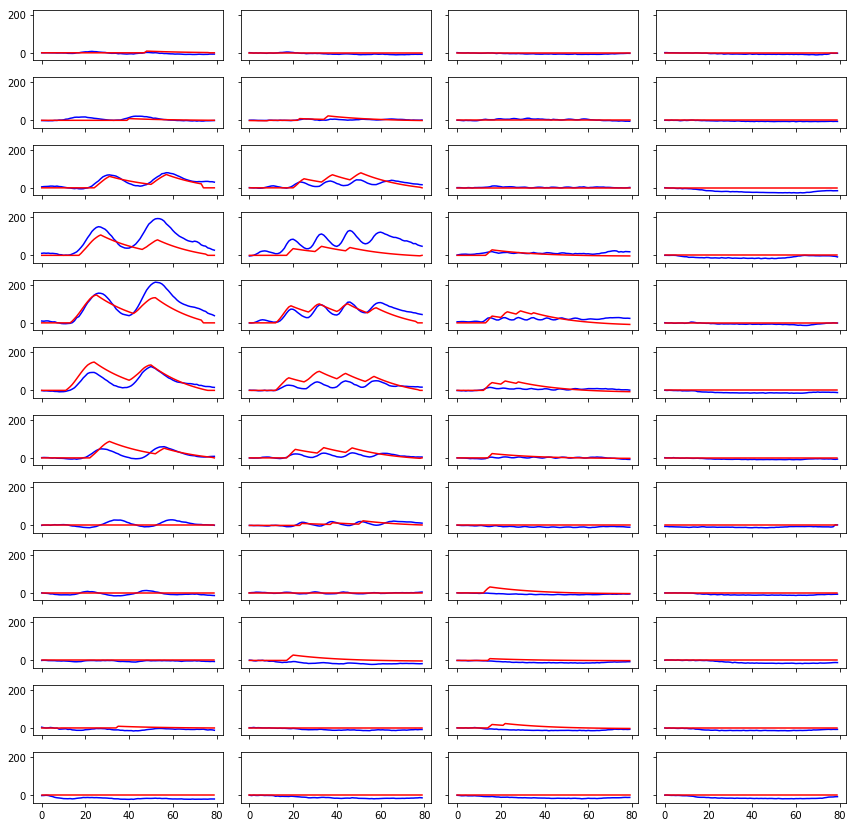

In [21]:
plot_data([T4_Gcamp, T4_model],c=['b','r'])

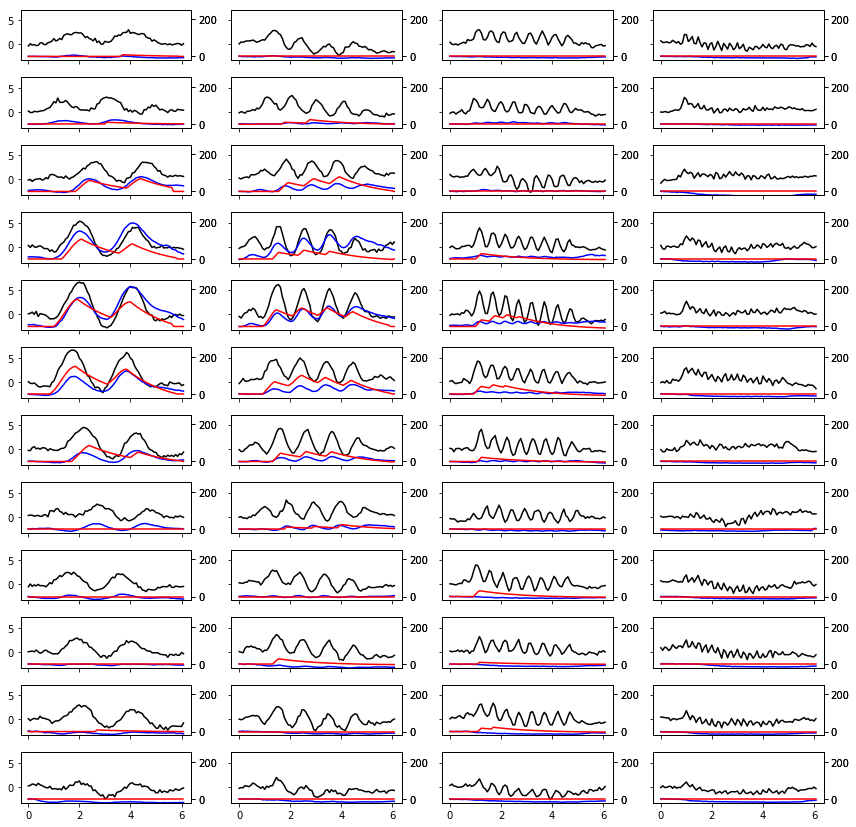

In [27]:
plot_data_twinaxis([T4_Arclight, T4_Gcamp, T4_model], c=['k','b','r'])

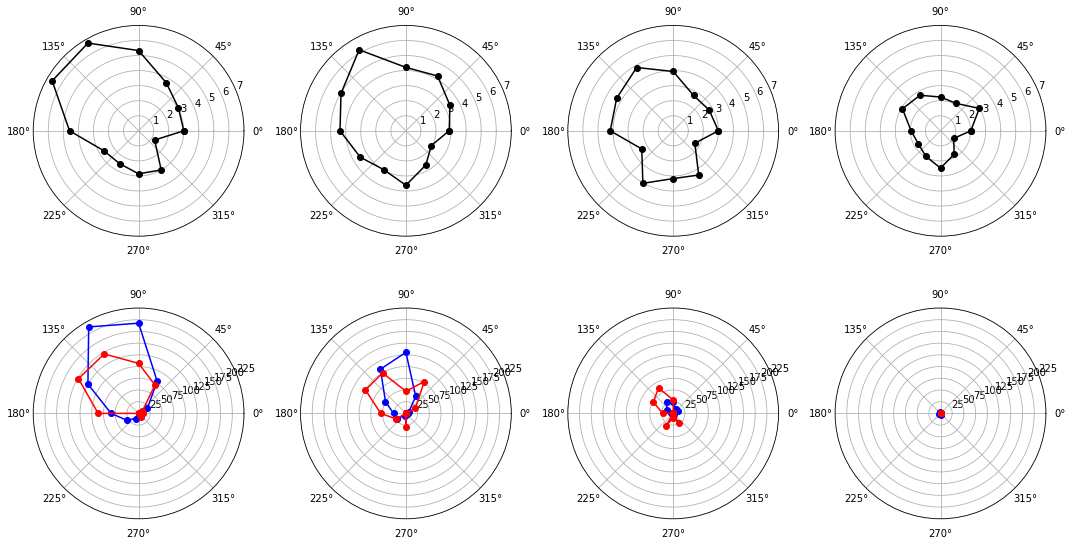

In [28]:
data_list = [T4_Arclight, T4_Gcamp, T4_model]
velocity = [15, 30, 60, 120]
peak_tuning = calc_peaktuning(data_list, speed=velocity)
plot_oripeaktuning(data_list,speed=velocity, color=['k','b','r'],title='Model3/PeakResponse_OrientationTuning_Model3',savefig=True);

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


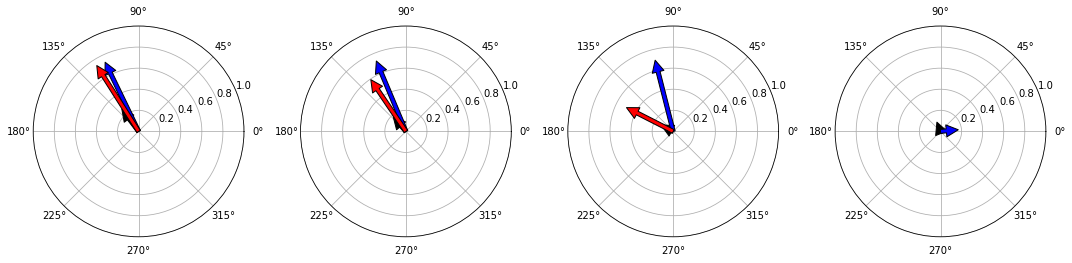

In [29]:
plot_Ldir(peak_tuning,title='Model3/Ldir',savefig=True);

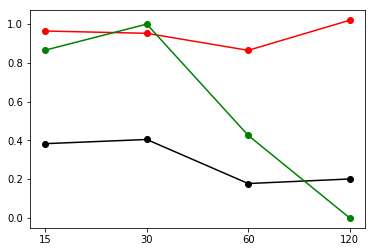

In [305]:
c = ['k','r','g']
label=['T4_Arclight','T4_Gcamp','T4_Ca_model']
for i in range(3):
    plt.plot(Ldir[i,:], color=c[i], marker='o',label=label[i]);
plt.xticks([0,1,2,3],[15,30,60,120])
#plt.legend();
plt.savefig('figures/Ldir.pdf',dpi=1000);

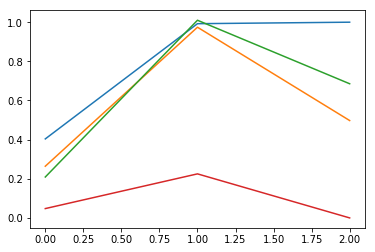

In [271]:
plt.plot(Ldir[]);

In [273]:
Ldir[0,:]

array([0.4036901 , 0.26413051, 0.20902469, 0.04770499])

In [280]:
PD = peak_tuning[2,1,4]
ND = peak_tuning[2,1,10]
Ldir = (PD-ND)/(PD+ND)
Ldir

1.0

In [283]:
Ldir[2,1]

1.0

In [256]:
Ldir[1,0]

0.9923491369976113

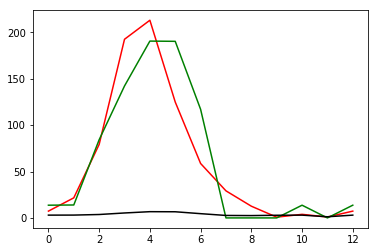

In [249]:
peak_tuning_gcamp_15 = T4_Gcamp[:,0:48:4].max(axis=0)
peak_tuning_gcamp_15 = np.append(peak_tuning_gcamp_15, peak_tuning_gcamp_15[0])

peak_tuning_model_15 = T4_model[:,0:48:4].max(axis=0)
peak_tuning_model_15 = np.append(peak_tuning_model_15, peak_tuning_model_15[0])

peak_tuning_arclight_15 = T4_Arclight[:,0:48:4].max(axis=0)
peak_tuning_arclight_15 = np.append(peak_tuning_arclight_15, peak_tuning_arclight_15[0])

plt.plot(peak_tuning_gcamp_15,'r');
plt.plot(peak_tuning_model_15,'g');
plt.plot(peak_tuning_arclight_15,'k');

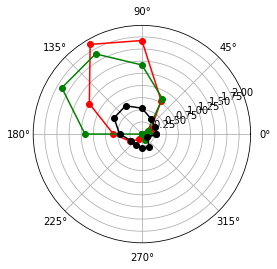

In [195]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection': 'polar'})
#ax1 = ax.twinx(projection='polar')
ax.plot(rotations_rad, peak_tuning_gcamp_15, marker ='o',color='r');
ax.plot(rotations_rad, peak_tuning_model_15, marker ='o',color='g');
ax.plot(rotations_rad, peak_tuning_arclight_15, marker ='o',color='k');

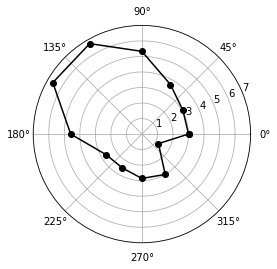

In [177]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection': 'polar'})
ax.plot(rotations_rad, peak_tuning_arclight_15, marker ='o',color='k');

In [156]:

rotations, rotations_rad

(array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
        330., 360.]),
 array([0.        , 0.52359878, 1.04719755, 1.57079633, 2.0943951 ,
        2.61799388, 3.14159265, 3.66519143, 4.1887902 , 4.71238898,
        5.23598776, 5.75958653, 6.28318531]))

In [88]:
gcamp_15 = T4_Gcamp[:,0:48:4]
model_15 = T4_model[:,0:48:4]
model_shift = shift_signal(gcamp_15, model_15, vel=15.0)
T4_model[:,0:48:4] = model_shift

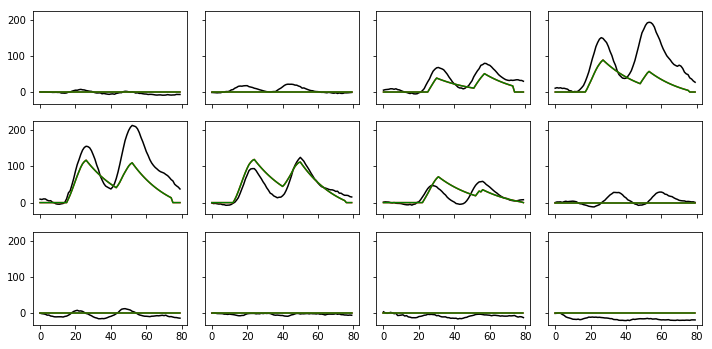

In [89]:
plot_data([gcamp_15, model_15, T4_model[:,0:48:4]], c=['k','r','g'], fig_size=(10,5))

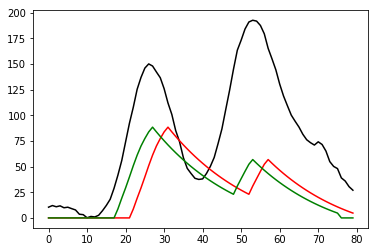

In [65]:
gcamp = T4_Gcamp[:,12]
model = T4_model[:,12]
model_shift = np.roll(model,np.argmax(gcamp[45:70])-np.argmax(model[45:70]),axis=0)
plt.plot(gcamp,'k')
plt.plot(model,'r')
plt.plot(model_shift,'g');

In [69]:
np.sqrt(mean_squared_error(gcamp, model_shift))

65.59555170223605

In [68]:
np.sqrt(np.mean((gcamp-model_shift)**2))

65.59555170223605

In [256]:
# error_list = []
# para_dict = {}
# counter = 0
# for thres in thres_val:
#     for tauhp in tauhp_val:
#         for taulp1 in taulp1_val:
#             for gain1 in gain1_val:
#                 for taulp2 in taulp2_val:
#                     for gain2 in gain2_val:
#                             T4Ca_model = Ca_model(T4_Arclight, thres, tauhp, taulp1, gain1, taulp2, gain2)
#                             T4Ca_model = shift_signal(T4_Gcamp, T4Ca_model) #align signals
#                             error1 = np.mean(np.sqrt(np.mean((T4_Gcamp-T4Ca_model)**2,axis=0)))
#                             error2 = np.sqrt(np.mean((T4_Gcamp.max(axis=0)-T4Ca_model.max(axis=0))**2)) #peakerror
#                             timeerror = 0.6 #weight for time error
#                             error = timeerror*error1 + (1.0-timeerror)*error2 #peak error aand time error combined
#                             error_list.append(error)
#                             para_dict[counter] = (thres, tauhp, taulp1, gain1, taulp2, gain2, tshift)
#                             counter +=1

KeyboardInterrupt: 

In [250]:
model_p = para_dict[np.argmin(error_list)]
(thres_model, tauhp_model, taulp1_model, gain1_model, taulp2_model, gain2_model, tshift_model) = model_p
(np.min(error_list),thres_model, tauhp_model, taulp1_model, gain1_model, taulp2_model, gain2_model)

(14.74965818066736, 3.2222222222222223, 4.0, 0.0, 0.0, 4.0, 100.0)

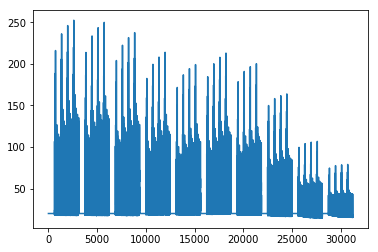

In [251]:
plt.plot(error_list)

In [252]:
T4_model = Ca_model(T4_Arclight, thres_model, tauhp_model, taulp1_model, gain1_model, taulp2_model, gain2_model)
T4_model = shift_signal(T4_Gcamp, T4_model) #align signals

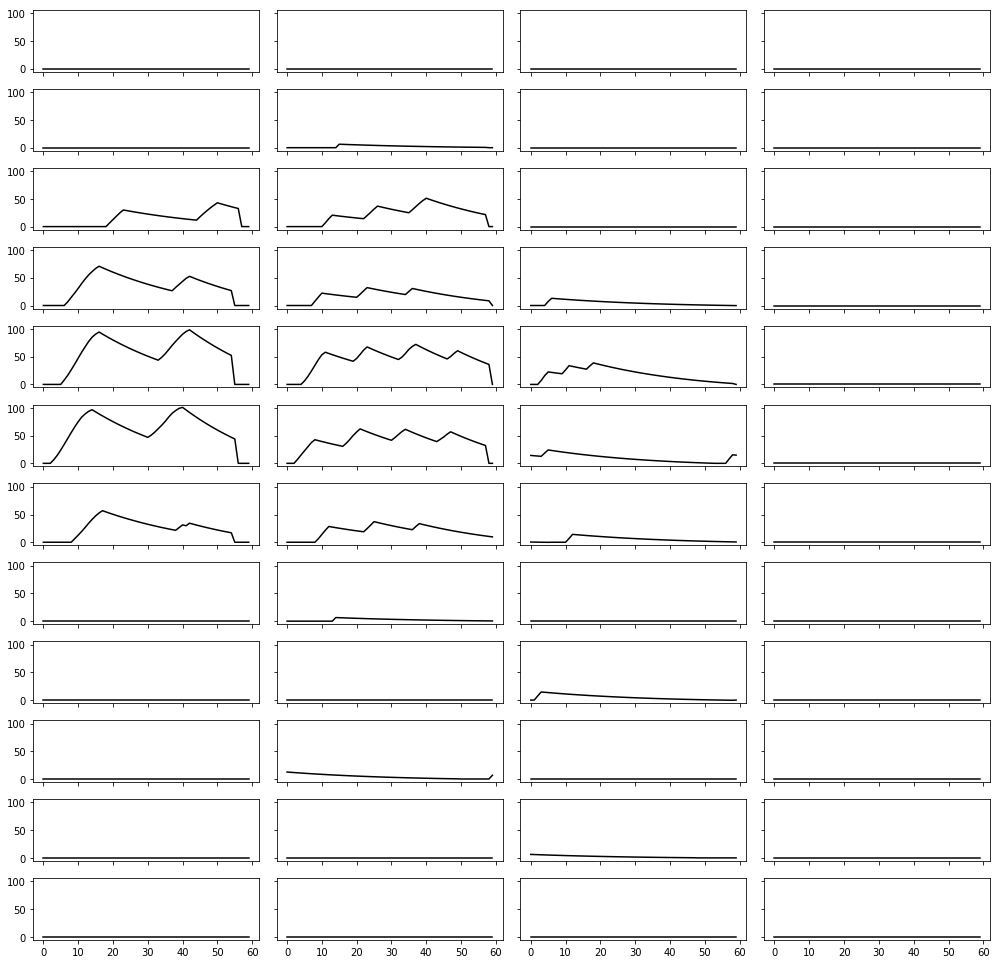

In [253]:
plot_data([T4_model])

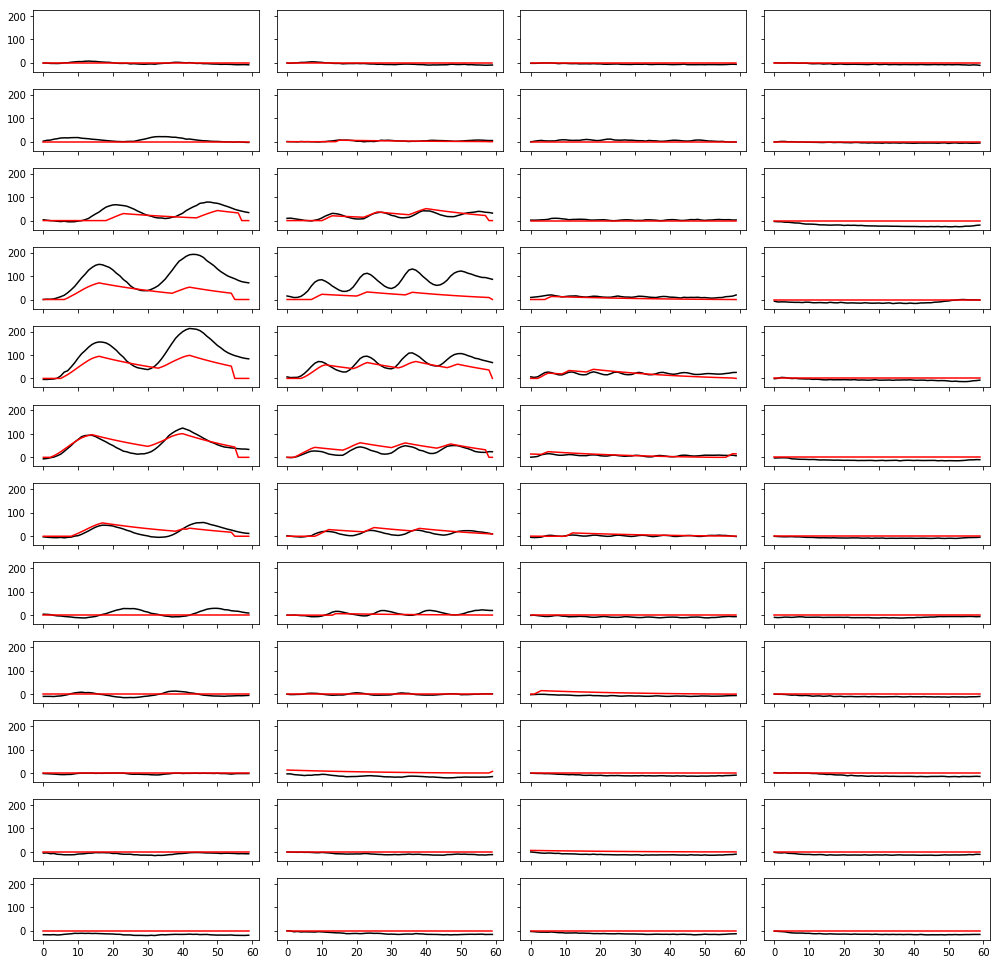

In [254]:
plot_data([T4_Gcamp, T4_model])

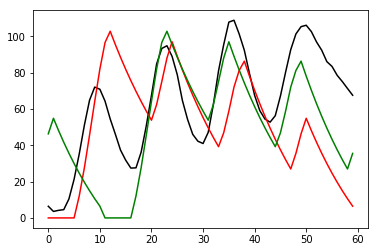

In [233]:
shift_columns = np.argmax(T4_Gcamp[0:25,:],axis=0)-np.argmax(T4_model[0:25,:],axis=0)
A = T4_model
r = shift_columns
rows, columns = np.ogrid[:A.shape[0], :A.shape[1]]
r[r < 0] += A.shape[0]
rows = rows - r[np.newaxis,:]
model_shift = A[rows, columns]
col = 17
gcamp = T4_Gcamp[:,col]
model = T4_model[:,col]
model_sh = model_shift[:,col]
plt.plot(gcamp,'k')
plt.plot(model,'r');
plt.plot(model_sh, 'g');

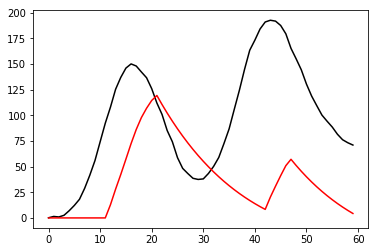

In [148]:
gcamp = T4_Gcamp[:,12]
model = T4_model[:,12]
plt.plot(gcamp,'k')
plt.plot(model,'r');

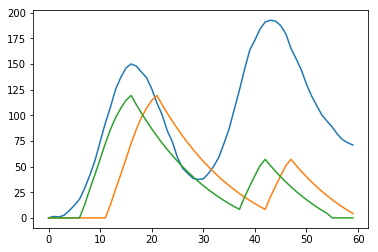

In [149]:
model_shift = np.roll(model,np.argmax(gcamp[0:25])-np.argmax(model[0:25]),axis=0)
plt.plot(gcamp)
plt.plot(model)
plt.plot(model_shift);

In [174]:
np.argmax(gcamp[0:25])-np.argmax(model[0:25])

-5

In [216]:
model_shift = T4_model.copy()
shift_columns = np.argmax(T4_Gcamp[0:25,:],axis=0)-np.argmax(T4_model[0:25,:],axis=0)
#[model_shift[:,i]=np.roll(model_shift[:,i],shift_columns[i],axis =0) for i in range(model_shift.shape[1])]

In [210]:
A = T4_model.T
r = shift_columns
rows, column_indices = np.ogrid[:A.shape[0], :A.shape[1]]

In [211]:
r[r < 0] += A.shape[1]
column_indices = column_indices - r[:,np.newaxis]

In [212]:
model_shift = A[rows, column_indices]
model_shift = model_shift.T

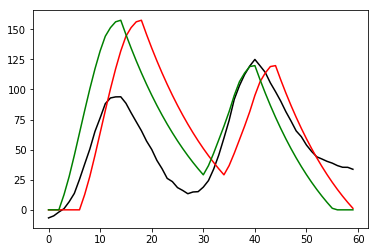

In [215]:
gcamp = T4_Gcamp[:,20]
model = T4_model[:,20]
model_sh = model_shift[:,20]
plt.plot(gcamp,'k')
plt.plot(model,'r');
plt.plot(model_sh, 'g');

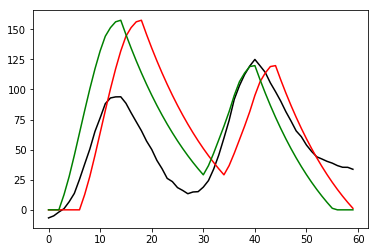

In [180]:
#model_shift = np.roll(T4_model,(np.argmax(T4_Gcamp[0:25,:],axis=0)-np.argmax(T4_model[0:25,:],axis=0)),axis=0);
model_shift = np.roll(T4_model,shift_columns[np.newaxis,:],axis=0);

ValueError: 'shift' and 'axis' should be scalars or 1D sequences

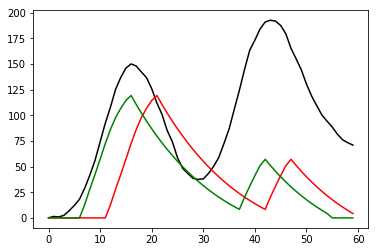

In [167]:
gcamp = T4_Gcamp[:,12]
model = T4_model[:,12]
model_sh = model_shift[:,12]
plt.plot(gcamp,'k')
plt.plot(model,'r');
plt.plot(model_sh, 'g');

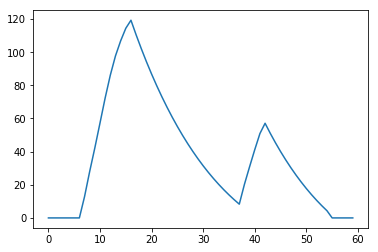

In [155]:
plt.plot(np.roll(T4_model[:,12],(np.argmax(T4_Gcamp[0:25,:],axis=0)-np.argmax(T4_model[0:25,:],axis=0))[12]))

In [158]:
s = np.argmax(T4_Gcamp[0:25,:],axis=0)-np.argmax(T4_model[0:25,:],axis=0)

In [161]:
s

array([ 13,   7,   4,   0,  10,  -2,  23,   2,  -3,  -2,   7,   0,  -5,
        -1,   0,   0,  -5,  11,  -1,   2,  -4,  -2,  -7,   2,  -5,  12,
         6,   0,  23,   0,   1,   7,  11,  20,  -1,   0,  20, -10,   0,
         0,  15,   0, -12,   0,  11,   0,   0,   0])

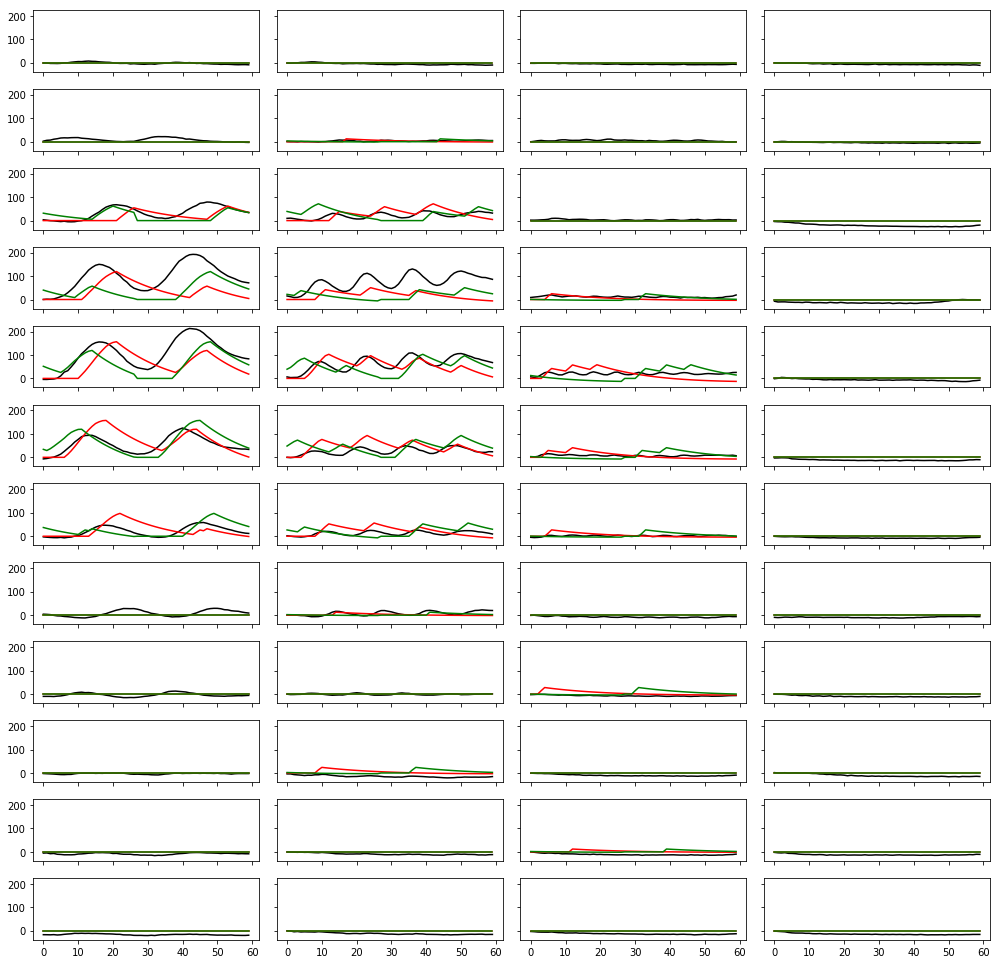

In [109]:
plot_data([T4_Gcamp, model, model_shift],c=['k','r','g'])

In [101]:
gcamp[0:25,:].shape

(25, 48)

In [90]:
np.argmax(gcamp[0:25])-np.argmax(model[0:25])

-2

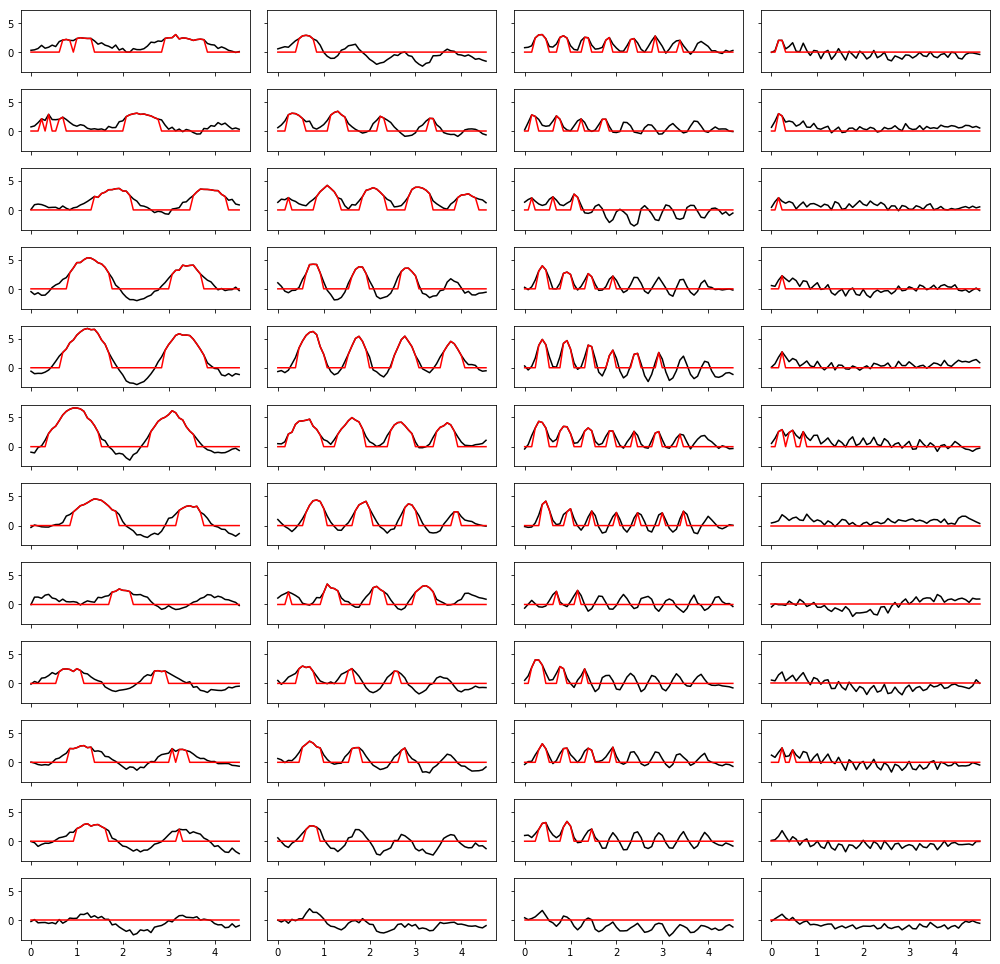

In [10]:
plot_data([T4_Arclight, threshold_cut(T4_Arclight, 2)])

In [12]:
T4_Arclight.min(), T4_Arclight.max()

(-2.886634351656312, 6.727594607112149)

In [193]:
A = np.array([[4, 0, 0],
              [1, 2, 3],
              [0, 0, 5]])
r = np.array([2, 0, -1])

In [194]:
rows, column_indices = np.ogrid[:A.shape[0], :A.shape[1]]

# Use always a negative shift, so that column_indices are valid.
# (could also use module operation)
r[r < 0] += A.shape[1]
column_indices = column_indices - r[:, np.newaxis]

result = A[rows, column_indices]

In [195]:
result

array([[0, 0, 4],
       [1, 2, 3],
       [0, 5, 0]])